<a href="https://colab.research.google.com/github/ziishanahmad/ai-web-image-scraper-trainer-model/blob/main/scrapping_image_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries for web scraping, file handling, and data processing
import requests
from bs4 import BeautifulSoup
import os
from urllib.parse import urljoin, urlparse
from collections import deque
import pandas as pd

def download_images_from_website(url, output_dir, csv_path, max_depth=3):
    """
    Download images from a website, save them to a directory, and record their paths and alt tags in a CSV file.

    Parameters:
    url (str): The starting URL to crawl.
    output_dir (str): The directory to save downloaded images.
    csv_path (str): The path to the CSV file to save image paths and alt tags.
    max_depth (int): The maximum depth to crawl for links.

    Returns:
    None
    """
    # Load existing CSV data if it exists, or create a new DataFrame
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        df = pd.DataFrame(columns=['image_path', 'alt_tag'])

    visited_urls = set()  # Track visited URLs to avoid duplicate processing
    queue = deque([(url, 0)])  # Queue to manage URLs with their depth level
    new_data = []  # List to store new image data

    while queue:
        current_url, depth = queue.popleft()  # Get URL and its depth level

        # Limit crawling depth
        if depth > max_depth:
            continue

        # Ensure unique URLs
        if current_url in visited_urls:
            continue
        visited_urls.add(current_url)

        try:
            # Request the current URL
            response = requests.get(current_url)
            soup = BeautifulSoup(response.text, 'html.parser')

            # Find all image tags on the page
            image_tags = soup.find_all('img')

            for img in image_tags:
                img_url = img.get('src')
                alt_tag = img.get('alt')

                # Skip images without alt tags
                if not alt_tag:
                    continue

                if img_url:
                    # Handle relative URLs
                    img_url = urljoin(current_url, img_url)

                    # Generate a filename based on the image URL
                    img_name = img_url.split('/')[-1]
                    img_path = os.path.join(output_dir, img_name)

                    # Check if image is already downloaded
                    if img_path in df['image_path'].values:
                        print(f"Image already downloaded: {img_path}")
                        continue

                    # Download the image
                    img_response = requests.get(img_url)

                    # Save the image
                    with open(img_path, 'wb') as f:
                        f.write(img_response.content)

                    # Store image path and alt tag
                    new_data.append((img_path, alt_tag))

                    # Print information
                    print(f"Downloaded: {img_path}, Alt Tag: {alt_tag}")

        except Exception as e:
            print(f"Error fetching {current_url}: {e}")

        # Find links to other pages and add to the queue
        if depth < max_depth:
            for link in soup.find_all('a', href=True):
                next_url = urljoin(current_url, link['href'])

                # Ensure the link is within the same domain
                if urlparse(next_url).netloc == urlparse(url).netloc:
                    queue.append((next_url, depth + 1))

        # Append new data to existing DataFrame and save to CSV
        new_df = pd.DataFrame(new_data, columns=['image_path', 'alt_tag'])
        df = pd.concat([df, new_df], ignore_index=True)
        df.to_csv(csv_path, index=False)

        print("Data saved to CSV.")

# Example usage to download images and create a dataset
website_url = 'https://www.apple.com/'
output_parent_directory = '/content/drive/My Drive/datasets/applescrapper1'  # Update with your desired parent directory
csv_file_path = '/content/drive/My Drive/datasets/ddata1.csv'  # Update with your CSV path
max_depth = 3  # Maximum depth level to crawl

# Create output directory if it does not exist
if not os.path.exists(output_parent_directory):
    os.makedirs(output_parent_directory)

# Download images and save their data to CSV
download_images_from_website(website_url, output_parent_directory, csv_file_path, max_depth)


In [5]:
# Step 1: Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Step 2: Import necessary libraries for data handling and machine learning
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check if GPU is available for faster training
if not tf.test.gpu_device_name():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(tf.test.gpu_device_name()))


Found GPU at: /device:GPU:0


In [8]:
# Step 3: Load CSV data containing image paths and alt tags
csv_file_path = '/content/drive/My Drive/datasets/ddata1.csv'  # Updated CSV path
df = pd.read_csv(csv_file_path)

# Step 4: Data preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2  # Split data into 80% training and 20% validation
)

# Prepare training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='image_path',
    y_col='alt_tag',
    target_size=(224, 224),  # Resize images as needed
    batch_size=32,
    class_mode='categorical',  # Adjust class mode as per your labels
    subset='training'
)

# Prepare validation data generator
val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='image_path',
    y_col='alt_tag',
    target_size=(224, 224),  # Resize images as needed
    batch_size=32,
    class_mode='categorical',  # Adjust class mode as per your labels
    subset='validation'
)


Found 45232 validated image filenames belonging to 597 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 18191 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 11308 validated image filenames belonging to 597 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 18191 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [9]:
# Step 5: Build and train the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import json

# Define model architecture (example CNN)
num_classes = len(train_generator.class_indices)  # Number of unique alt tags

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjust output units for number of unique alt tags
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=5,  # Reduced number of epochs for quicker training
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Save the class indices to a JSON file
class_indices = train_generator.class_indices
with open('/content/drive/My Drive/datasets/class_indices.json', 'w') as f:
    json.dump(class_indices, f)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1414/1414 [==============================] - 558s 393ms/step - loss: 0.7893 - accuracy: 0.8387 - val_loss: 0.1705 - val_accuracy: 0.9558
Epoch 2/5
1414/1414 [==============================] - 579s 409ms/step - loss: 0.1714 - accuracy: 0.9412 - val_loss: 0.0880 - val_accuracy: 0.9710
Epoch 3/5
1414/1414 [==============================] - 579s 409ms/step - loss: 0.1498 - accuracy: 0.9490 - val_loss: 0.0653 - val_accuracy: 0.9770
Epoch 4/5
1414/1414 [==============================] - 551s 389ms/step - loss: 0.1191 - accuracy: 0.9566 - val_loss: 0.0668 - val_accuracy: 0.9790
Epoch 5/5
1414/1414 [==============================] - 543s 384ms/step - loss: 0.1199 - accuracy: 0.9555 - val_loss: 0.0676 - val_accuracy: 0.9790


In [10]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Step 6: Save the trained model to Google Drive
model.save('/content/drive/My Drive/datasets/model.h5')


354/354 [==============================] - 135s 380ms/step - loss: 0.0676 - accuracy: 0.9790
Validation Accuracy: 97.90%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 63ms/step


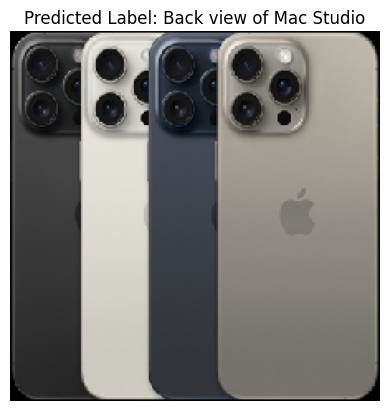

In [13]:
# Step 7: Predict labels for new images
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import json

# Load the pre-trained model
model_path = '/content/drive/My Drive/datasets/model.h5'  # Path to the saved model
model = load_model(model_path)

# Load the class indices from the JSON file
class_indices_path = '/content/drive/My Drive/datasets/class_indices.json'  # Path to the class indices file
with open(class_indices_path, 'r') as f:
    class_indices = json.load(f)
labels = {v: k for k, v in class_indices.items()}  # Map indices to labels

# Define the function to predict image label
def predict_image_label(image_path, model, labels):
    """
    Predict the label of a given image using the trained model.

    Parameters:
    image_path (str): The path to the image file.
    model (tf.keras.Model): The trained Keras model.
    labels (dict): A dictionary mapping class indices to labels.

    Returns:
    tuple: The image object and its predicted label.
    """
    img = image.load_img(image_path, target_size=(224, 224))  # Load and resize the image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize and expand dimensions

    predictions = model.predict(img_array)  # Predict the label
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class with highest probability

    return img, labels[predicted_class]

# Predict and display the label for a new image
new_image_path = '/content/drive/My Drive/datasets/applescrapper1/hero_iphone_pro_max__bsan8nevcgty_large.jpg'  # Update with the path to your new image
img, predicted_label = predict_image_label(new_image_path, model, labels)

# Convert the image to a NumPy array and normalize it for display
img_array = np.array(img) / 255.0

# Display the image with its predicted label
plt.imshow(img_array)  # Display normalized image
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()
